#Importando Bibliotecas

In [ ]:
#Se necessário, instalar tirando o # das linhas inferiores
#!pip install statsforecast
#!pip install --upgrade statsmodels
#!pip install pmdarima
#!pip install prophet
#!pip install sklearn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError as KerasMeanSquaredError
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.losses import MeanSquaredError

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

#Dados

##Preço

In [ ]:
df = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view', skiprows=1, thousands='.', decimal=',')[0]
df.head()

,0,1
0,28/03/2024,86.17
1,27/03/2024,84.94
2,26/03/2024,85.91
3,25/03/2024,86.18
4,22/03/2024,84.87


In [ ]:
def excluiDadosNulos(df):
    if 0 not in df.isna().sum().values:
        df = df.dropna()

In [ ]:
def tipaDados(df):
    df['data'] = df['data'].str.replace('/', '-')
    df['data'] = pd.to_datetime(df['data'], format='%d-%m-%Y')
    return df

In [ ]:
def renomeiaColunas(df):
    df.rename(columns={0: 'data', 1: 'preco'}, inplace=True)
    return df

In [ ]:
df = renomeiaColunas(df)
df.head()

,data,preco
0,28/03/2024,86.17
1,27/03/2024,84.94
2,26/03/2024,85.91
3,25/03/2024,86.18
4,22/03/2024,84.87


In [ ]:
df.head()

,data,preco
0,28/03/2024,86.17
1,27/03/2024,84.94
2,26/03/2024,85.91
3,25/03/2024,86.18
4,22/03/2024,84.87


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11140 entries, 0 to 11139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    11140 non-null  object 
 1   preco   11140 non-null  float64
dtypes: float64(1), object(1)
memory usage: 174.2+ KB


In [ ]:
df['data'] = pd.to_datetime(df['data'])

# Exibindo o DataFrame após a conversão
print(df)

            data  preco
0     2024-03-28  86.17
1     2024-03-27  84.94
2     2024-03-26  85.91
3     2024-03-25  86.18
4     2024-03-22  84.87
...          ...    ...
11135 1987-05-26  18.63
11136 1987-05-25  18.60
11137 1987-05-22  18.55
11138 1987-05-21  18.45
11139 1987-05-20  18.63

[11140 rows x 2 columns]


<ipython-input-429-82e16d51cf8b>:1: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [ ]:
df.isnull().sum()

data     0
preco    0
dtype: int64

In [ ]:
df.shape

(11140, 2)

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
data,11140,2006-07-21 08:42:21.328545792,1987-05-20 00:00:00,1998-05-07 18:00:00,2007-03-12 12:00:00,2014-11-28 06:00:00,2024-03-28 00:00:00,NaN
preco,11140.0,52.931762,9.1,20.47,48.04,76.1325,143.95,33.222445


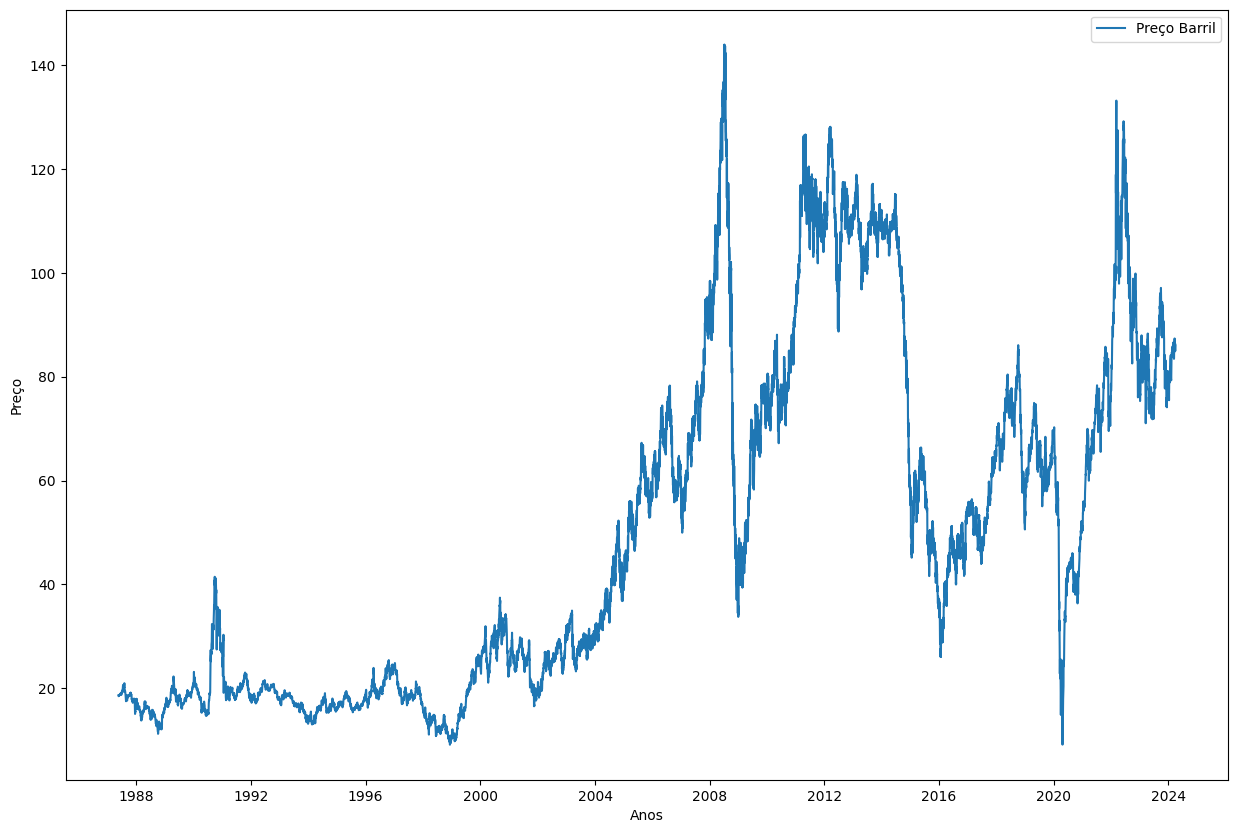

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df['data'], df['preco'], label='Preço Barril')
plt.xlabel('Anos')
plt.ylabel('Preço')
plt.legend(loc='best')
plt.show()

In [ ]:
#Filtrando os dados
df = df[['preco', 'data']].set_index('data')

In [ ]:
df['MM30'] = df['preco'].rolling(30).mean().shift() #média móvel
df['MM180'] = df['preco'].rolling(180).mean().shift() #média móvel

#Rolling para deslocamento. Este parâmetro especifica o número de observações usadas para calcular a estatística
#shift é utilizado para deslocar o índice de DataFrame por um número especificado de períodos com uma freqüência de tempo opcional

In [ ]:
df.head()

,preco,MM30,MM180
data,,,
2024-03-28,86.17,NaN,NaN
2024-03-27,84.94,NaN,NaN
2024-03-26,85.91,NaN,NaN
2024-03-25,86.18,NaN,NaN
2024-03-22,84.87,NaN,NaN


In [ ]:
df.tail()

,preco,MM30,MM180
data,,,
1987-05-26,18.63,18.929000,18.257611
1987-05-25,18.60,18.900667,18.270000
1987-05-22,18.55,18.870667,18.281667
1987-05-21,18.45,18.839667,18.295278
1987-05-20,18.63,18.810333,18.307889


In [ ]:
#pq o indice é importante
df.loc['2020-08-07']

preco    44.070000
MM30     42.741000
MM180    51.244722
Name: 2020-08-07 00:00:00, dtype: float64

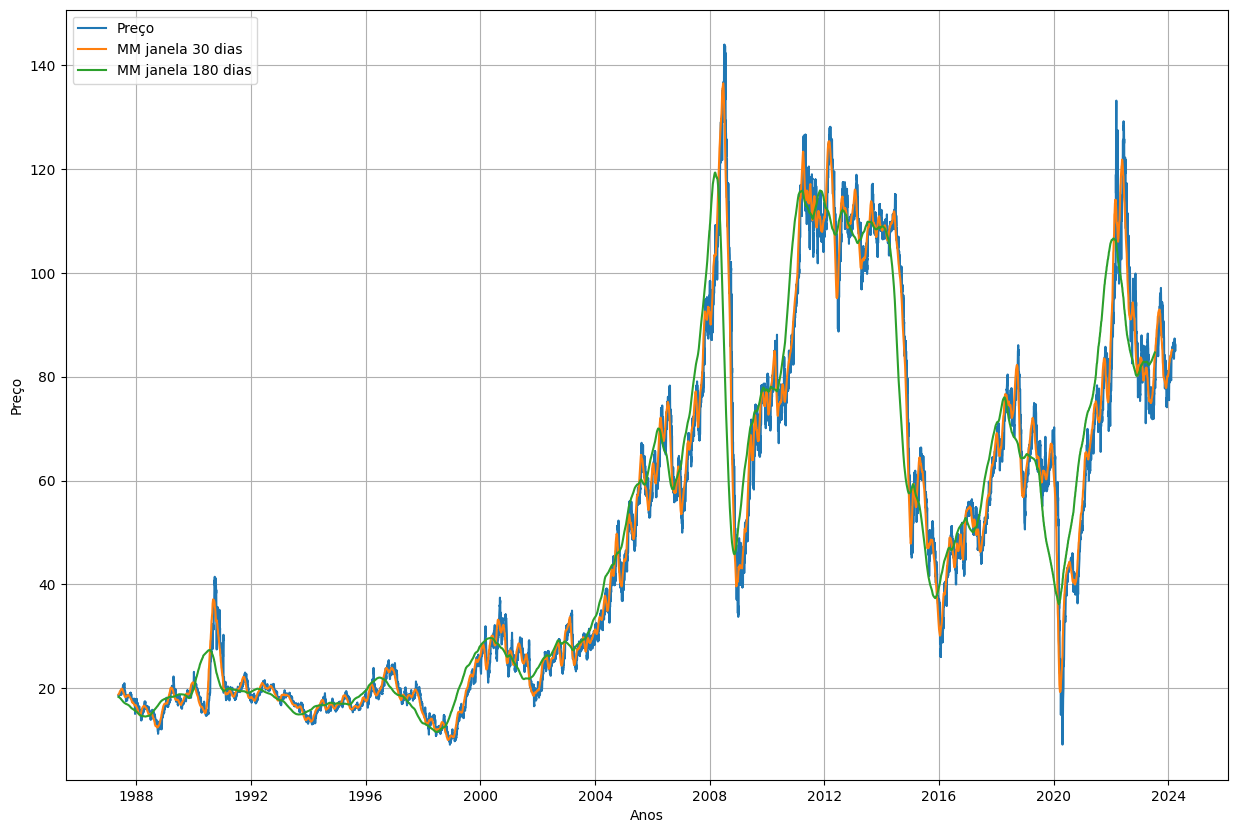

In [ ]:
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['preco'], label='Preço')
plt.plot(df['MM30'], label='MM janela 30 dias')
plt.plot(df['MM180'], label='MM janela 180 dias')
plt.xlabel('Anos')
plt.ylabel('Preço')
plt.legend(loc=2)
plt.show()

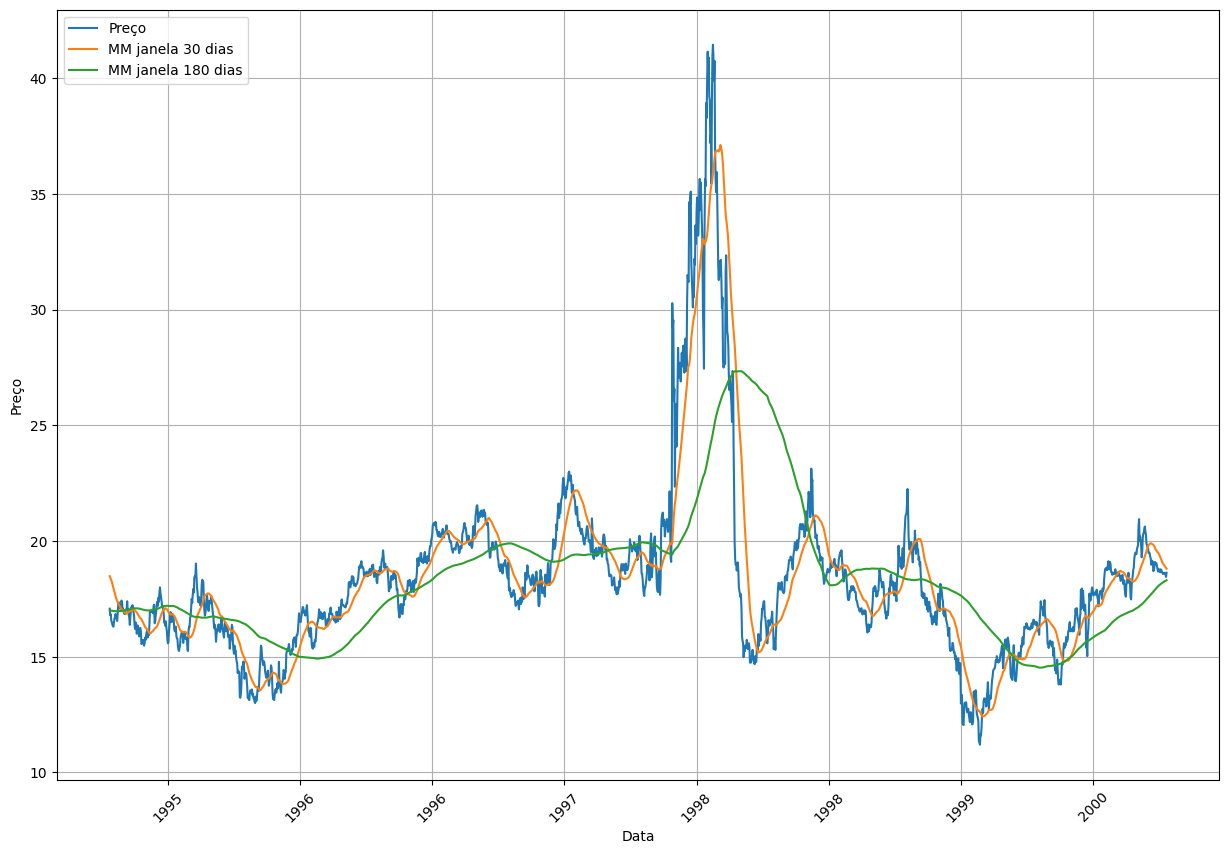

In [ ]:
import matplotlib.pyplot as plt

# Certifique-se de que o índice do DataFrame seja do tipo DateTime
df.index = pd.to_datetime(df.index)

limit = 2000

plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df.reset_index()['preco'][-limit:], label='Preço')
plt.plot(df.reset_index()['MM30'][-limit:], label='MM janela 30 dias')
plt.plot(df.reset_index()['MM180'][-limit:], label='MM janela 180 dias')
plt.xlabel('Data')  # Define o rótulo do eixo x como 'Data'
plt.ylabel('Preço')
plt.legend(loc=2)

# Define os rótulos do eixo x como datas
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x para melhor legibilidade
plt.show()


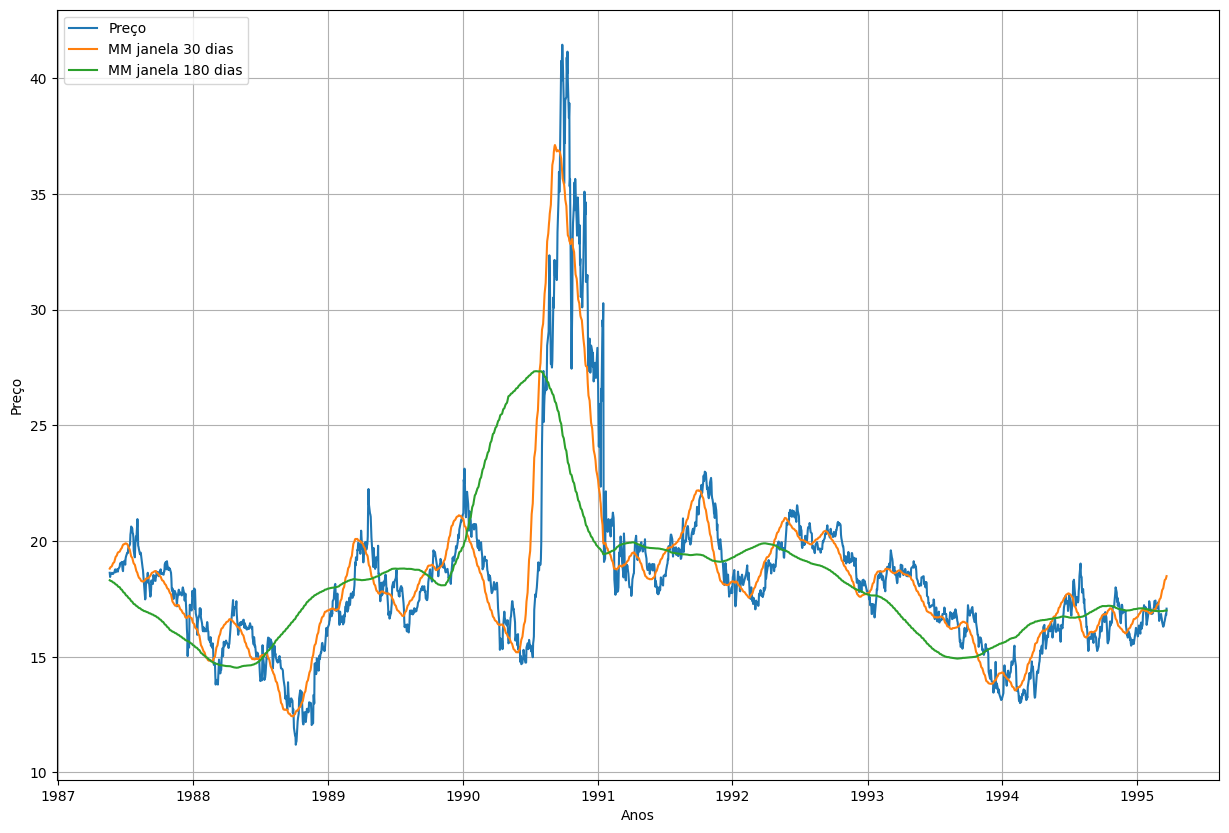

In [ ]:
limit = 2000

# Redefinir o índice
#df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df['preco'][-limit:], label='Preço')
plt.plot(df['MM30'][-limit:], label='MM janela 30 dias')
plt.plot(df['MM180'][-limit:], label='MM janela 180 dias')
plt.xlabel('Anos')
plt.ylabel('Preço')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.legend(loc=2)
plt.show()

##Desvio Padrão

In [ ]:
# Armazene o DataFrame original antes de resetar
#df_original = df.copy()

# Reset do índice
#df.reset_index(drop=True, inplace=True)

# Se agora você quiser restaurar o DataFrame original com o índice
#df = df_original.copy()


#/ Calcular desvio padrão móvel
window = 30  # Janela de 30 dias
df['DesvioPadrao'] = df['preco'].rolling(window=window).std()

# Plotar usando Seaborn
plt.figure(figsize=(15, 10))

sns.lineplot(data=df, x='data', y='preco', label='Preço')
sns.lineplot(data=df, x='data', y='DesvioPadrao', label='Desvio Padrão Móvel 30 Dias', color='green')

# Estilização do gráfico
plt.xlabel('Anos')
plt.ylabel('Preço')
#plt.xticks(df_ibov['ds'][::365], df_ibov['ds'][::365].dt.year, rotation=-45)
plt.title('Desvio Padrão Móvel e Ibovespa ao longo do tempo')

plt.legend()
plt.tight_layout()
plt.show()

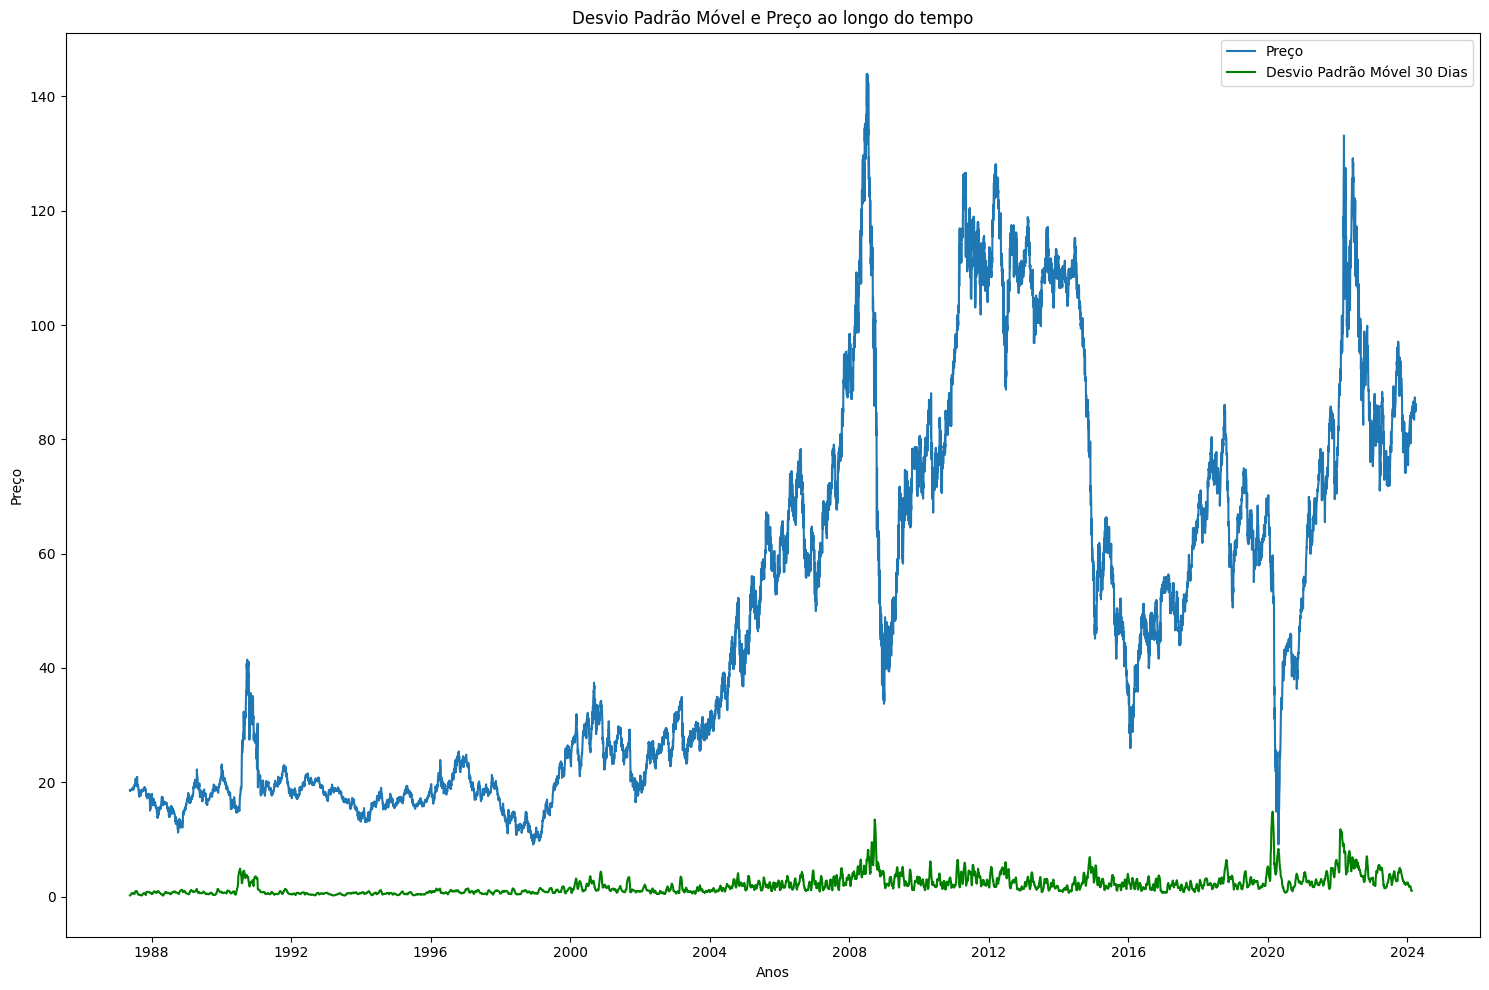

In [ ]:
# Armazene o DataFrame original antes de resetar
#df_original = df.copy()
# Reset do índice
#df.reset_index(drop=True, inplace=True)
# Se agora você quiser restaurar o DataFrame original com o índice
#df = df_original.copy()
# Supondo que 'data' seja o nome da coluna que você deseja converter para datetime
#df['data'] = pd.to_datetime(df.index)

# Calcular desvio padrão móvel
window = 30  # Janela de 30 dias
df['DesvioPadrao'] = df['preco'].rolling(window=window).std()

# Plotar usando Seaborn
plt.figure(figsize=(15, 10))

sns.lineplot(data=df, x='data', y='preco', label='Preço')
sns.lineplot(data=df, x='data', y='DesvioPadrao', label='Desvio Padrão Móvel 30 Dias', color='green')

# Estilização do gráfico
plt.xlabel('Anos')
plt.ylabel('Preço')

# Ajustando o formato das datas no eixo x
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

plt.title('Desvio Padrão Móvel e Preço ao longo do tempo')

plt.legend()
plt.tight_layout()
plt.show()



##As Bandas de Bollinger

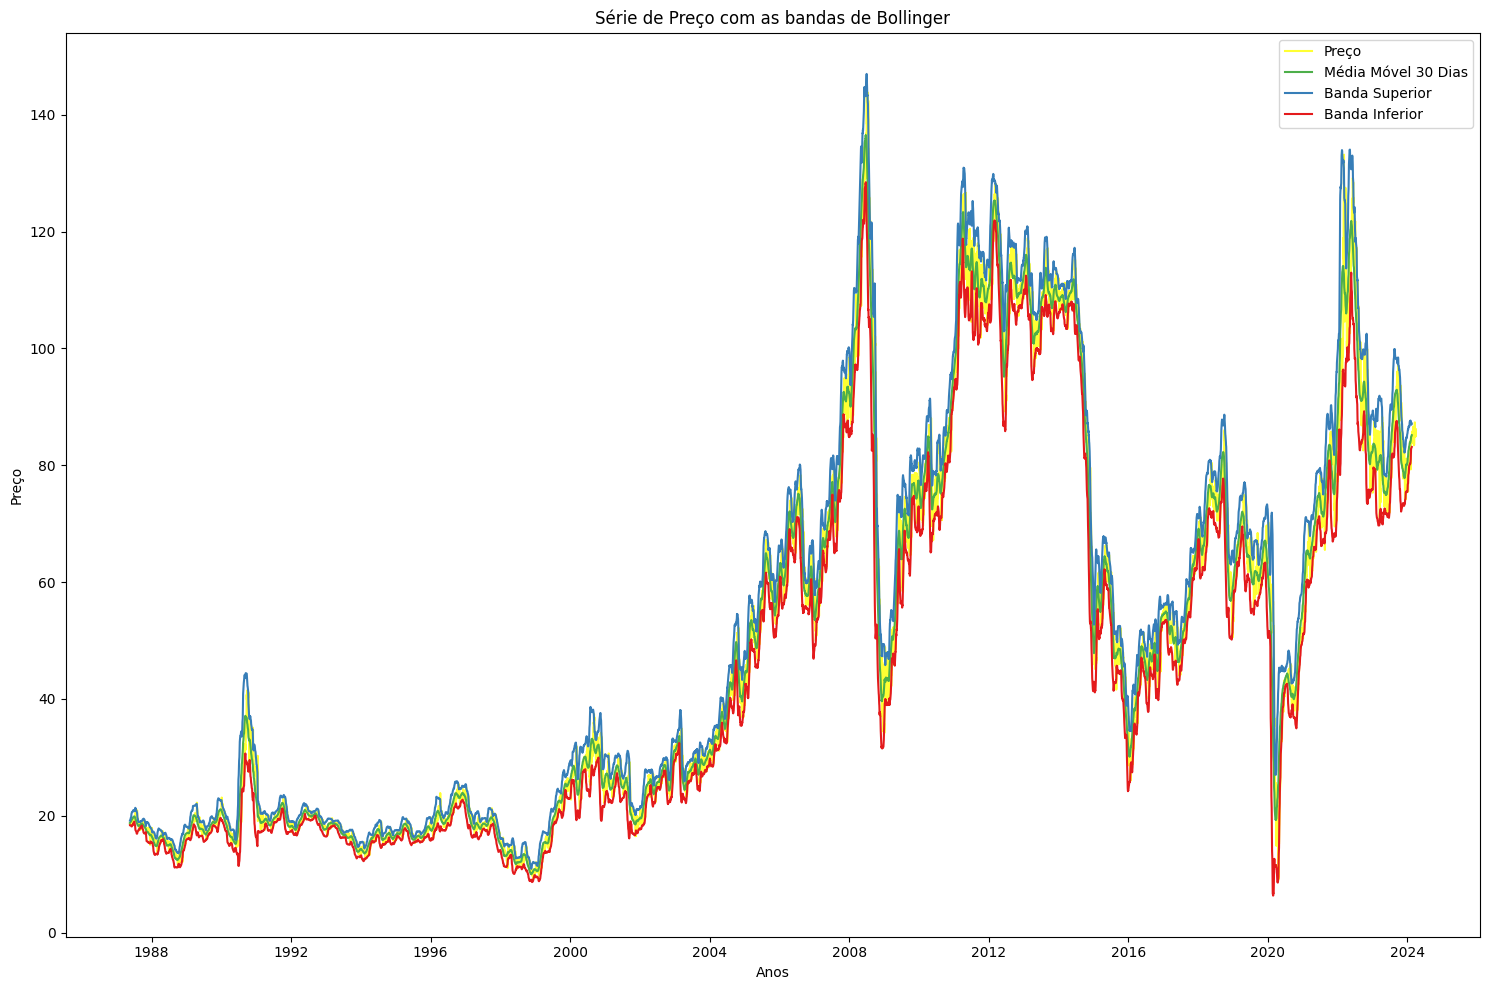

In [ ]:
# Calcular média móvel e desvio padrão
window = 30
df['MM30'] = df['preco'].rolling(window=window).mean()
df['DesvioPadrao'] = df['preco'].rolling(window=window).std()

# Calculando as Bollinger Bands
k = 2
df['Banda Superior'] = df['MM30'] + (df['DesvioPadrao'] * k)
df['Banda Inferior'] = df['MM30'] - (df['DesvioPadrao'] * k)

# Plotar usando Seaborn
plt.figure(figsize=(15, 10))

palette = sns.color_palette("Set1")

sns.lineplot(data=df, x='data', y='preco', label='Preço', color=palette[5])
sns.lineplot(data=df, x='data', y='MM30', label='Média Móvel 30 Dias', color=palette[2])
sns.lineplot(data=df, x='data', y='Banda Superior', label='Banda Superior', color=palette[1])
sns.lineplot(data=df, x='data', y='Banda Inferior', label='Banda Inferior', color=palette[0])

# Estilização do gráfico
plt.xlabel('Anos')
plt.ylabel('Preço')
plt.title('Série de Preço com as bandas de Bollinger')

plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#pq o indice é importante
#df.loc['2020-08-07']

##Decomposição e Dickey-Fuller

In [ ]:
resultados = seasonal_decompose(df['preco'], model='additive', period=12)

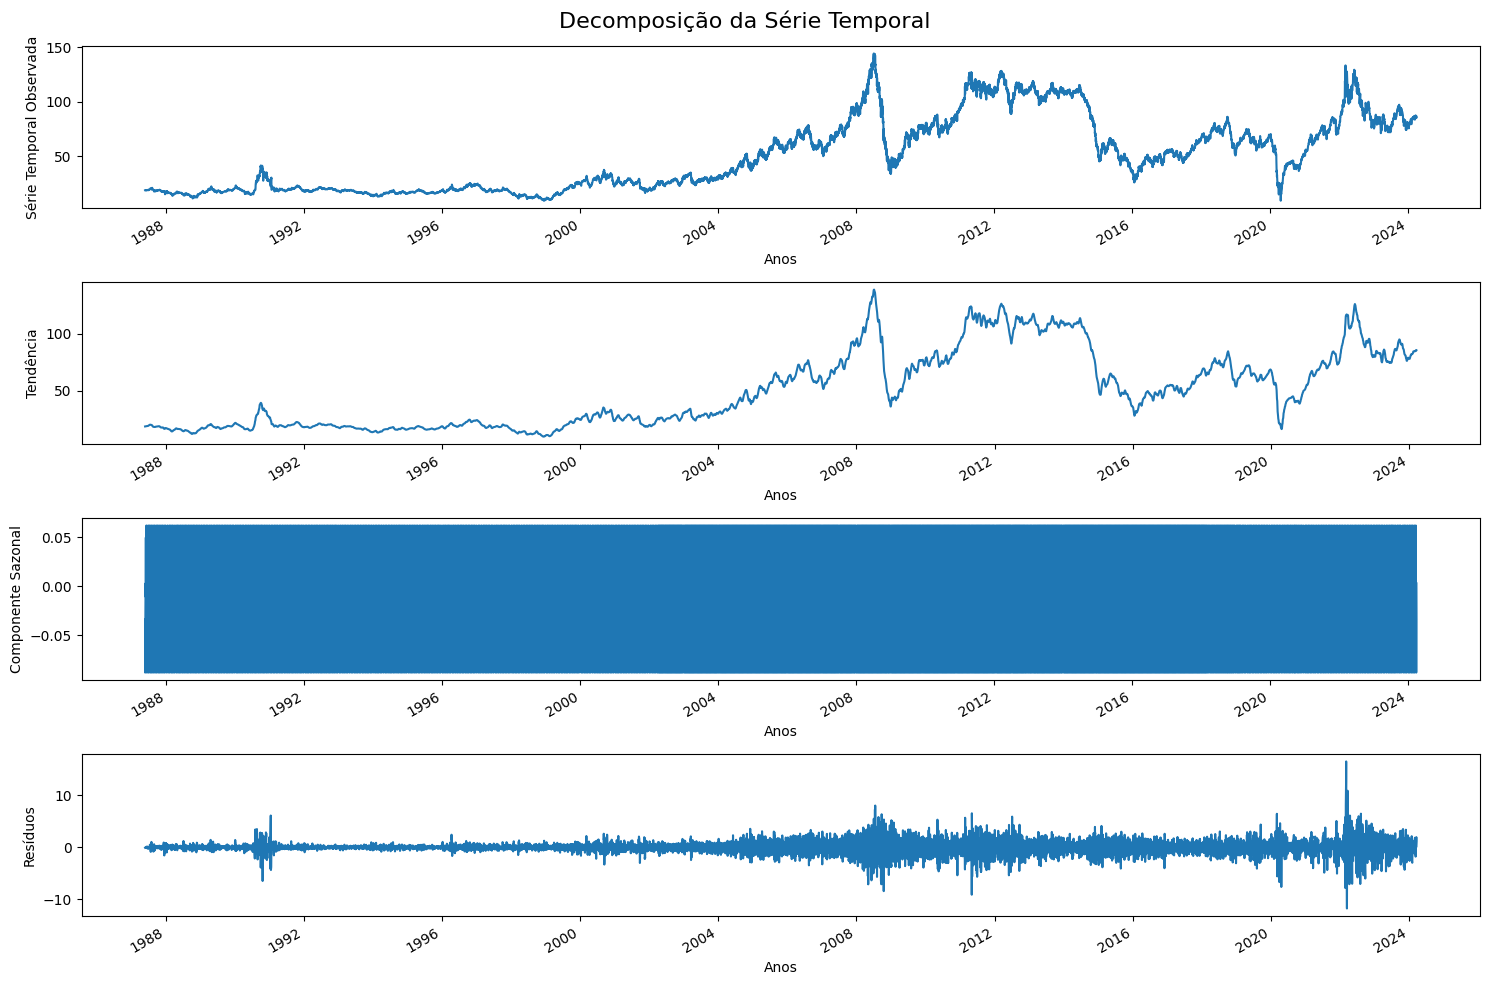

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1, label='Ibovespa')
ax1.set_ylabel('Série Temporal Observada')
ax1.set_xlabel('Anos')

resultados.trend.plot(ax=ax2)
ax2.set_ylabel('Tendência')
ax2.set_xlabel('Anos')

resultados.seasonal.plot(ax=ax3)
ax3.set_ylabel('Componente Sazonal')
ax3.set_xlabel('Anos')

resultados.resid.plot(ax=ax4)
ax4.set_ylabel('Resíduos')
ax4.set_xlabel('Anos')

plt.suptitle('Decomposição da Série Temporal', fontsize=16)
plt.tight_layout()
plt.show()

# ARIMA - Redução da Série Temporal - 1º ACF| PACF

##Determinando datas

In [ ]:
df = df.sort_index(ascending=True)

In [ ]:
print(df)

            preco       MM30      MM180  DesvioPadrao  Banda Superior  \
data                                                                    
1987-05-20  18.63  18.789667  18.307889      0.194803       19.179272   
1987-05-21  18.45  18.810333  18.295278      0.209605       19.229544   
1987-05-22  18.55  18.839667  18.281667      0.218813       19.277293   
1987-05-25  18.60  18.870667  18.270000      0.241103       19.352872   
1987-05-26  18.63  18.900667  18.257611      0.261401       19.423469   
...           ...        ...        ...           ...             ...   
2024-03-22  84.87        NaN        NaN           NaN             NaN   
2024-03-25  86.18        NaN        NaN           NaN             NaN   
2024-03-26  85.91        NaN        NaN           NaN             NaN   
2024-03-27  84.94        NaN        NaN           NaN             NaN   
2024-03-28  86.17        NaN        NaN           NaN             NaN   

            Banda Inferior  
data                 

In [ ]:
#Determinando o range para trabalhar, depois de 2020 da pandemia
start_date_new = '2023-01-01'
end_date_new = '2024-03-30'

# Filtrar as datas desejadas
df_1 = df[(df.index >= start_date_new) & (df.index <= end_date_new)]

df_1.head()

,preco,MM30,MM180,DesvioPadrao,Banda Superior,Banda Inferior
data,,,,,,
2023-01-02,82.82,82.443000,81.185722,3.273557,88.990113,75.895887
2023-01-03,80.36,82.548333,81.272333,3.336343,89.221020,75.875647
2023-01-04,75.31,82.701667,81.387889,3.338007,89.377681,76.025653
2023-01-05,76.73,82.995000,81.486944,3.039350,89.073699,76.916301
2023-01-06,76.41,83.232000,81.583000,2.801911,88.835822,77.628178


In [ ]:
df_1['preco'].tail()

data
2024-03-22    84.87
2024-03-25    86.18
2024-03-26    85.91
2024-03-27    84.94
2024-03-28    86.17
Name: preco, dtype: float64

In [ ]:
print(df)

            preco       MM30      MM180  DesvioPadrao  Banda Superior  \
data                                                                    
1987-05-20  18.63  18.789667  18.307889      0.194803       19.179272   
1987-05-21  18.45  18.810333  18.295278      0.209605       19.229544   
1987-05-22  18.55  18.839667  18.281667      0.218813       19.277293   
1987-05-25  18.60  18.870667  18.270000      0.241103       19.352872   
1987-05-26  18.63  18.900667  18.257611      0.261401       19.423469   
...           ...        ...        ...           ...             ...   
2024-03-22  84.87        NaN        NaN           NaN             NaN   
2024-03-25  86.18        NaN        NaN           NaN             NaN   
2024-03-26  85.91        NaN        NaN           NaN             NaN   
2024-03-27  84.94        NaN        NaN           NaN             NaN   
2024-03-28  86.17        NaN        NaN           NaN             NaN   

            Banda Inferior  
data                 

In [ ]:
# Cálculo da ACF e PACF para as colunas 'data' e 'preco' do DataFrame
lag_acf = acf(df_1['preco'], nlags=40)  # Autocorrelation Function (ACF)
lag_pacf = pacf(df_1['preco'], nlags=40, method='ols')  # Partial Autocorrelation Function (PACF)
conf_int = 1.96 / np.sqrt(len(df_1['preco']))  # Intervalo de confiança

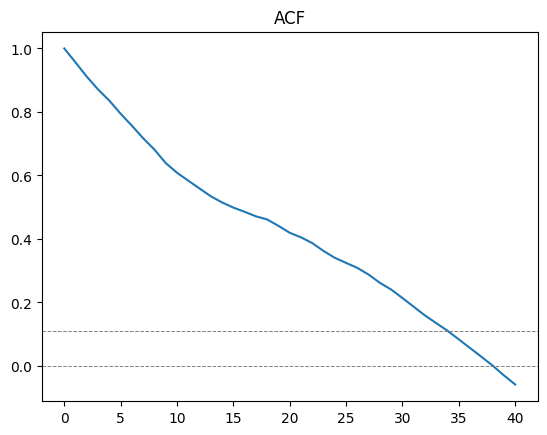

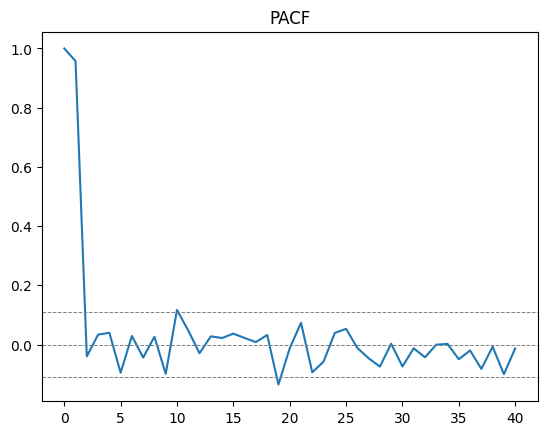

In [ ]:
plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_1) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_1) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_1) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_1) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("PACF")
plt.show()

##Decomposição e Dickey-Fuller

In [ ]:
resultados = seasonal_decompose(df_1['preco'], model='additive', period=12)

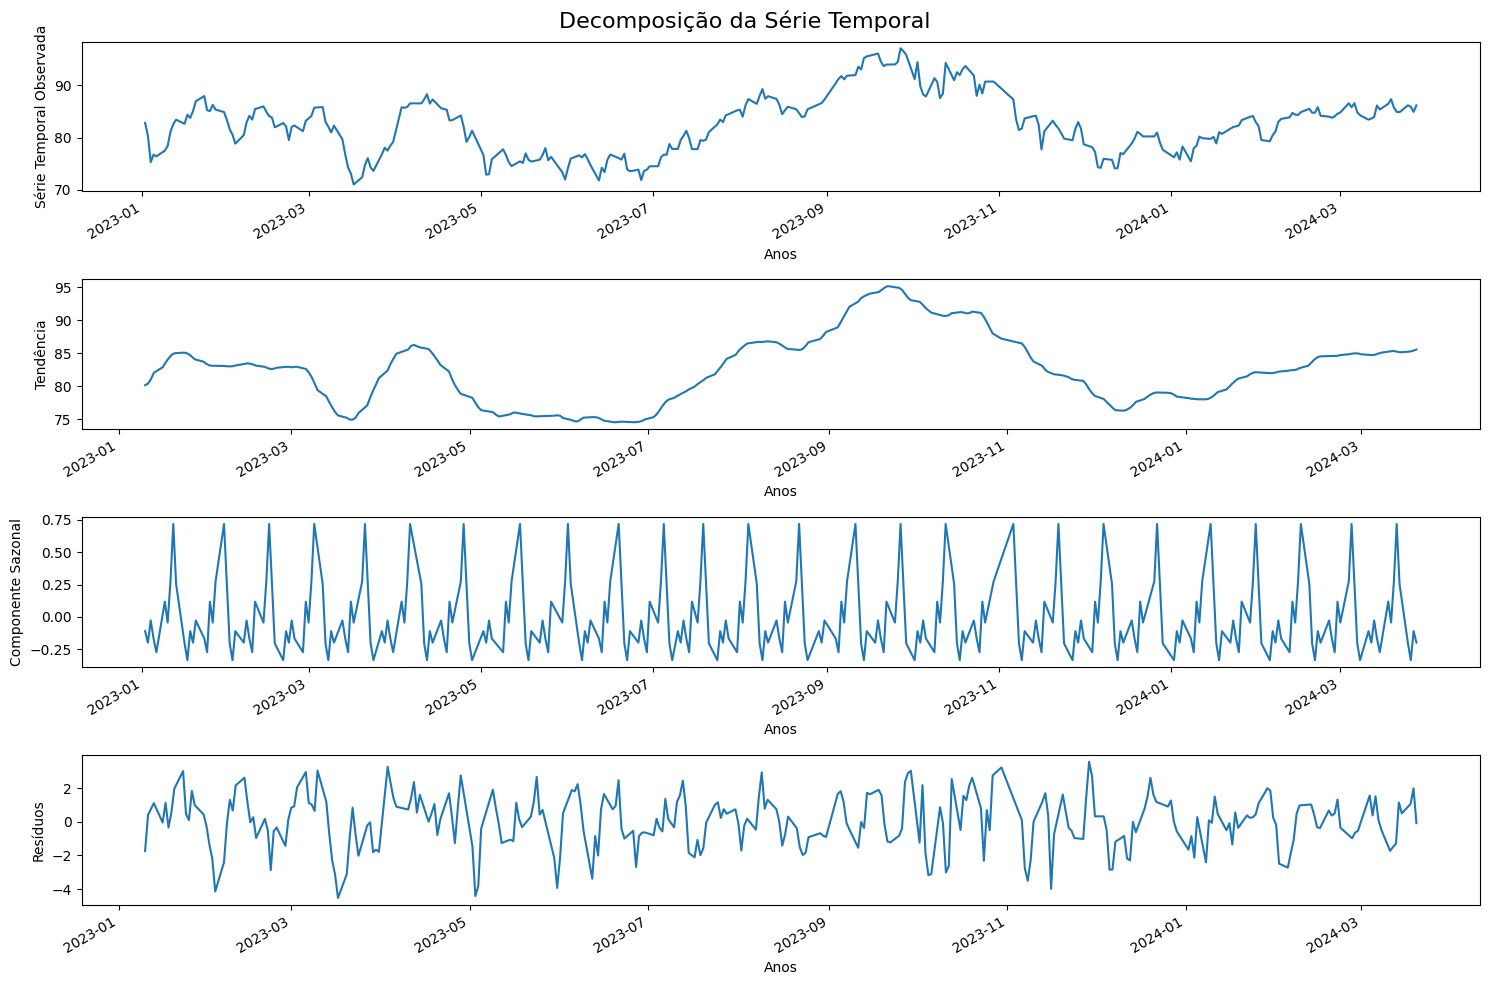

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

resultados.observed.plot(ax=ax1, label='Preço')
ax1.set_ylabel('Série Temporal Observada')
ax1.set_xlabel('Anos')

resultados.trend.plot(ax=ax2)
ax2.set_ylabel('Tendência')
ax2.set_xlabel('Anos')

resultados.seasonal.plot(ax=ax3)
ax3.set_ylabel('Componente Sazonal')
ax3.set_xlabel('Anos')

resultados.resid.plot(ax=ax4)
ax4.set_ylabel('Resíduos')
ax4.set_xlabel('Anos')

plt.suptitle('Decomposição da Série Temporal', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
X = df_1.preco.values

In [ ]:
result = adfuller(X)

print("Teste ADF")
print(f"Teste estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste estatístico: -2.580457229156038
P-Value: 0.09710400304907812
Valores críticos:
	1%: -3.4514162625887037
	5%: -2.8708187088091406
	10%: -2.5717136883095675


No seu caso, o valor-p é 0.0958, que é maior do que o nível de significância comumente usado de 0.05. Isso significa que não temos evidências suficientes para rejeitar a hipótese nula de que a série possui raiz unitária, ou seja, não podemos concluir que a série é estacionária com base apenas neste teste.

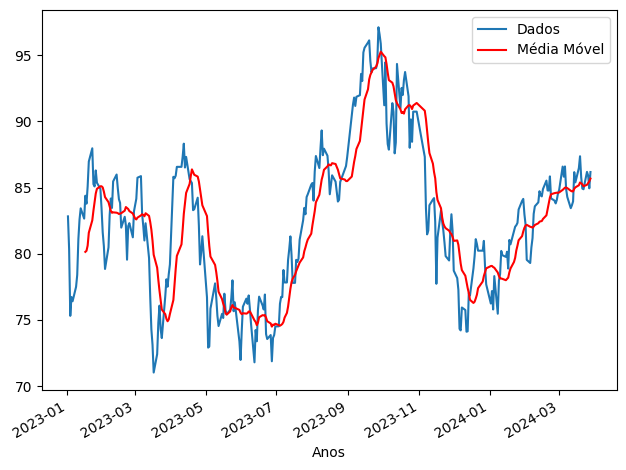

In [ ]:
#media movel
ma = df_1['preco'].rolling(12).mean()

f, ax = plt.subplots()

df_1['preco'].plot(ax=ax, legend=True, label='Dados')
ma.plot(ax=ax, color="r", legend=True, label='Média Móvel')
plt.xlabel('Anos')
plt.tight_layout()

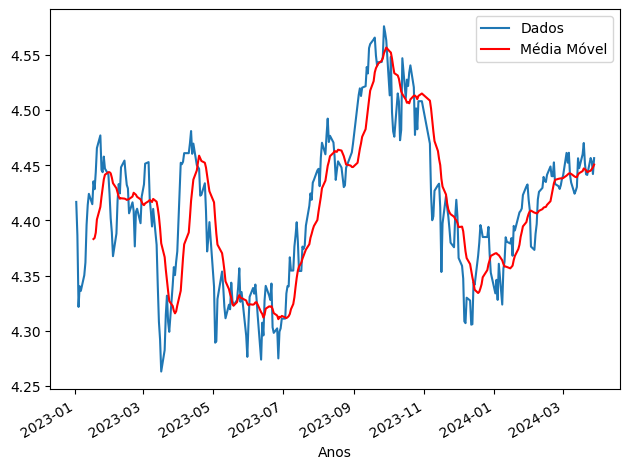

In [ ]:
#aplicar log (transformando escala)
df_log = np.log(df_1['preco'])
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=True, label='Dados')
ma_log.plot(ax=ax, color="r", legend=True, label='Média Móvel')
plt.xlabel('Anos')
plt.tight_layout()

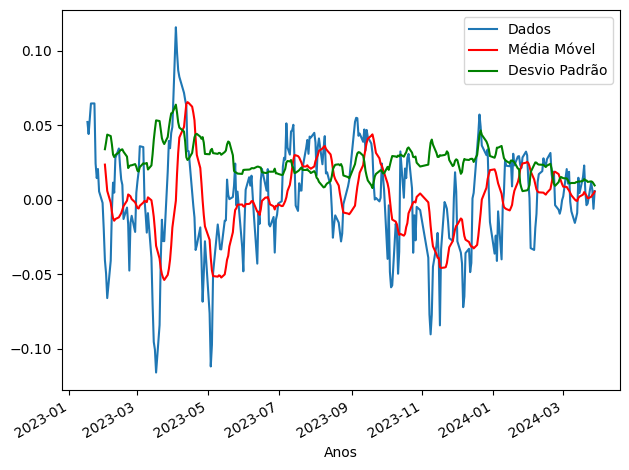

In [ ]:
#fez o drop na para que seja retirado valores nulos - o 12 é fazendo apenas dos 12 meses
df_1_s = (df_log - ma_log).dropna() #subtrai da média

ma_s = df_1_s.rolling(12).mean() #média móvel

std = df_1_s.rolling(12).std() #desvio padrao

f, ax = plt.subplots()
df_1_s.plot(ax=ax, legend=True, label='Dados')
ma_s.plot(ax=ax, color="r", legend=True, label='Média Móvel')
std.plot(ax=ax, color="g", legend=True, label='Desvio Padrão')
plt.xlabel('Anos')
plt.tight_layout()

##Teste ADF Novamente

In [ ]:
X_s = df_1_s.values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste estatístico: -5.813461227361621
P-Value: 4.346963245963393e-07
Valores críticos:
	1%: -3.4524859843440754
	5%: -2.871288184343229
	10%: -2.571964047565425


Dado que o valor-p é extremamente baixo (2.3668591304456707e-05) e é menor que o nível de significância comumente utilizado de 0.05, podemos rejeitar a hipótese nula de que a série possui raiz unitária. Isso sugere que há evidências suficientes para concluir que a série é estacionária.

##Diferenciação

Teste ADF
Teste estatístico: -7.902795104969235
P-Value: 4.141940197032244e-12
Valores críticos:
	1%: -3.4529449243622383
	5%: -2.871489553425686
	10%: -2.572071437887033


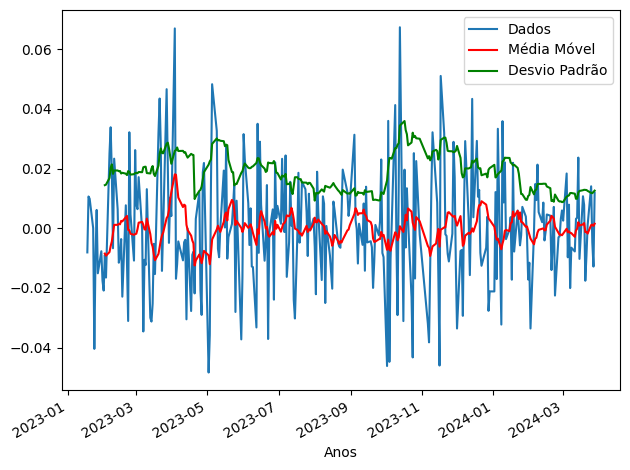

In [ ]:
#1 derivada
df_diff = df_1_s.diff(1)
ma_diff = df_diff.rolling(12).mean()

#desvio padrão
std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=True, label='Dados')
ma_diff.plot(ax=ax, color="r", legend=True, label='Média Móvel')
std_diff.plot(ax=ax, color="g", legend=True, label='Desvio Padrão')
plt.xlabel('Anos')
plt.tight_layout()

X_diff = df_diff.dropna().values#tem q dropar
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

p-value está cada vez mais proximo de zero

Ela é estacionaria.

#ARIMA - após diferenciação

In [ ]:
lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

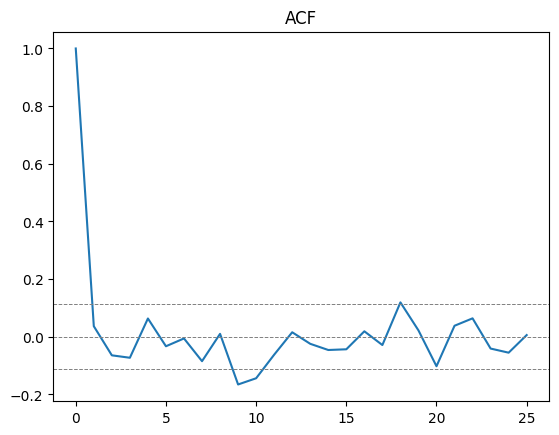

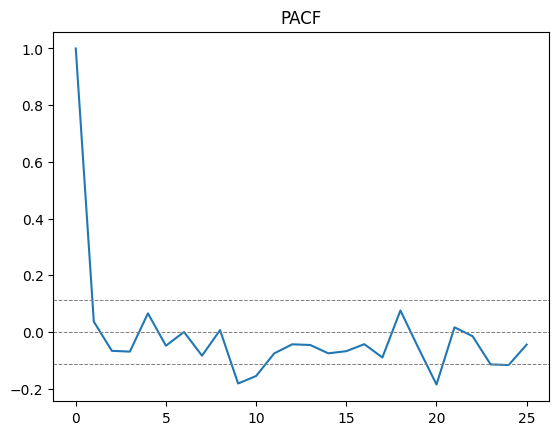

In [ ]:
plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray', linewidth=0.7)

plt.title("PACF")
plt.show()

NO ARIMA - FUNCIONARIA ASSIM:

* A(x,y, z)
* x= é onde o ponto pega no limite superior na primeira vez do ACF que seria o numero 18
* y = é onde o ponto passa o limite superir no PACF na primeira vez - que seria 1

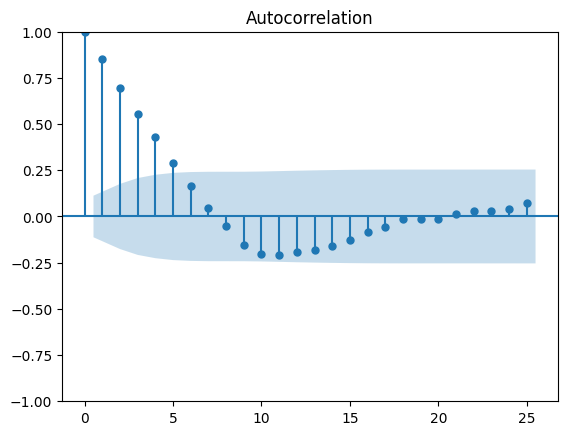

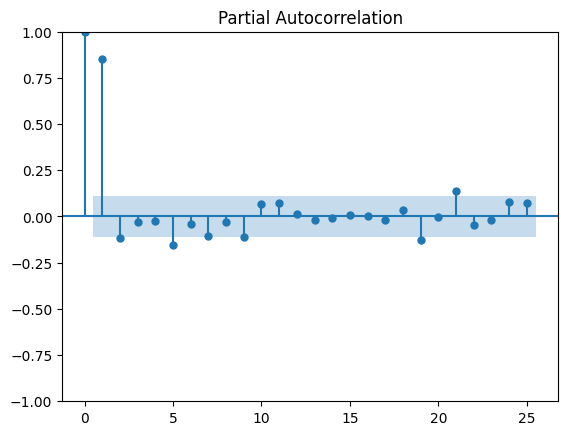

In [ ]:
plot_acf(df_1_s)
plot_pacf(df_1_s)

plt.show()

* o cone azul é a largura banda de confiança
* a correlação parcial, tem a negativa

Conclusão

Ao observar os gráficos de ACF e PACF, notamos que ambos representam consistentemente o intervalo de confiança em todos os lags. Isso sugere que, após a diferenciação, a série temporal não apresenta autocorrelações significativas em seus lags. Esse é um bom indicativo de que a diferenciação foi eficaz em remover padrões e tendências da série, tornando-a estacionária e, assim, mais adequada para modelagem ARIMA.

##RSS

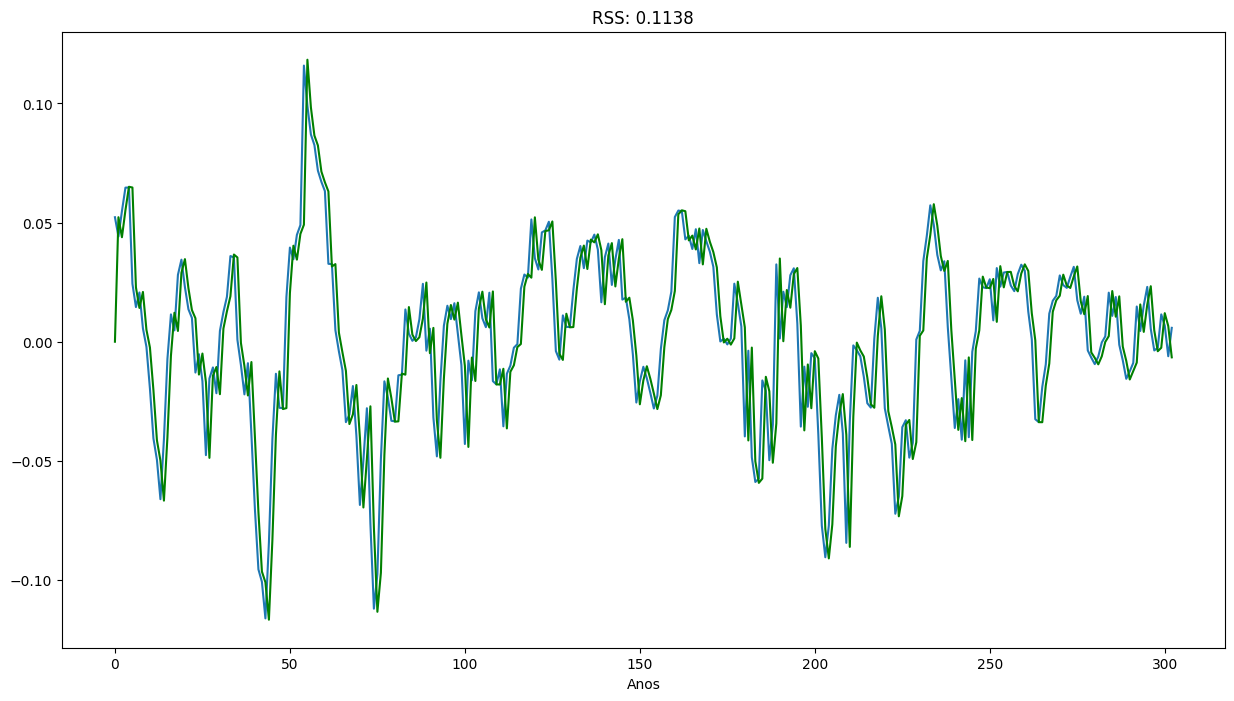

Plotting AR model


In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Resetando o índice do DataFrame
df_1_s_reset = df_1_s.reset_index(drop=True)

# Criando o modelo ARIMA
model = ARIMA(df_1_s_reset, order=(1, 1, 0))  # (p, d, q)

# Ajustando o modelo
results_AR = model.fit()

# Criando o gráfico
plt.figure(figsize=(15, 8))
plt.plot(df_1_s_reset)
plt.plot(results_AR.fittedvalues, color='g')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues - df_1_s_reset)**2))
plt.xlabel('Anos')
plt.show()

print('Plotting AR model')


Uma RSS de 0,1148, nesse contexto, indica que há uma quantidade de variabilidade não explicada pelo modelo, pois os resíduos não são todos iguais a zero. Quanto menor for a RSS, melhor o modelo se ajusta aos dados, pois isso indica que os resíduos são menores, ou seja, que o modelo está explicando uma maior proporção da variabilidade nos dados observados.

##MAPE

In [ ]:
# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = df_1_s.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = df_log.iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(df_1_s, predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 454.45%


Quando você vê um MAPE de 425.93%, isso significa que, em média, os erros absolutos das previsões do seu modelo são cerca de 425.93% do valor real.

##Prophet

In [ ]:
df.tail()

,preco,MM30,MM180,DesvioPadrao,Banda Superior,Banda Inferior
data,,,,,,
2024-03-22,84.87,NaN,NaN,NaN,NaN,NaN
2024-03-25,86.18,NaN,NaN,NaN,NaN,NaN
2024-03-26,85.91,NaN,NaN,NaN,NaN,NaN
2024-03-27,84.94,NaN,NaN,NaN,NaN,NaN
2024-03-28,86.17,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_1.tail()

,preco,MM30,MM180,DesvioPadrao,Banda Superior,Banda Inferior
data,,,,,,
2024-03-22,84.87,NaN,NaN,NaN,NaN,NaN
2024-03-25,86.18,NaN,NaN,NaN,NaN,NaN
2024-03-26,85.91,NaN,NaN,NaN,NaN,NaN
2024-03-27,84.94,NaN,NaN,NaN,NaN,NaN
2024-03-28,86.17,NaN,NaN,NaN,NaN,NaN


In [ ]:
from datetime import datetime

# Definindo a data de início como 2023-01-01
data_inicio = datetime(2023, 1, 1)

# Definindo a data final como a data de hoje
data_fim = datetime.now()

# Resetando o índice para tornar a coluna 'data' acessível novamente
df_reset = df.reset_index()

# Renomeando as colunas e criando a coluna 'unique_id'
df = df_reset[['data', 'preco']].rename(columns={'data': 'ds', 'preco': 'y'})
df['unique_id'] = 'Preco'
df.dropna(inplace=True)

# Filtrando o DataFrame para incluir apenas os dados entre a data de início e a data final
df = df[(df['ds'] >= data_inicio) & (df['ds'] <= data_fim)]

df.head()


,ds,y,unique_id
10826,2023-01-02,82.82,Preco
10827,2023-01-03,80.36,Preco
10828,2023-01-04,75.31,Preco
10829,2023-01-05,76.73,Preco
10830,2023-01-06,76.41,Preco


In [ ]:
# Resetando o índice para tornar a coluna 'data' acessível novamente
#df_reset = df.reset_index()

# Renomeando as colunas e criando a coluna 'unique_id'
#df = df_reset[['data', 'preco']].rename(columns={'data': 'ds', 'preco': 'y'})
#df['unique_id'] = 'Preco'
#df.dropna(inplace=True)
#df.head()


In [ ]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (251, 3)
testing data size : (63, 3)


In [ ]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=24, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t28b1zp/e7vans__.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t28b1zp/g54kz8n8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66870', 'data', 'file=/tmp/tmp4t28b1zp/e7vans__.json', 'init=/tmp/tmp4t28b1zp/g54kz8n8.json', 'output', 'file=/tmp/tmp4t28b1zp/prophet_modelkhqtw034/prophet_model-20240406211210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-02,82.606660,80.101991,87.852418,82.606660,82.606660,1.447549,1.447549,1.447549,0.565456,0.565456,0.565456,0.882093,0.882093,0.882093,0.0,0.0,0.0,84.054209
1,2023-01-03,82.563543,79.587123,87.499087,82.563543,82.563543,0.996125,0.996125,0.996125,0.565456,0.565456,0.565456,0.430669,0.430669,0.430669,0.0,0.0,0.0,83.559668
2,2023-01-04,82.520426,79.552954,87.108109,82.520426,82.520426,0.664892,0.664892,0.664892,0.565456,0.565456,0.565456,0.099436,0.099436,0.099436,0.0,0.0,0.0,83.185317
3,2023-01-05,82.477308,79.190775,86.858199,82.477308,82.477308,0.540607,0.540607,0.540607,0.565456,0.565456,0.565456,-0.024849,-0.024849,-0.024849,0.0,0.0,0.0,83.017915
4,2023-01-06,82.434191,79.581027,87.264768,82.434191,82.434191,1.031790,1.031790,1.031790,0.565456,0.565456,0.565456,0.466334,0.466334,0.466334,0.0,0.0,0.0,83.465981


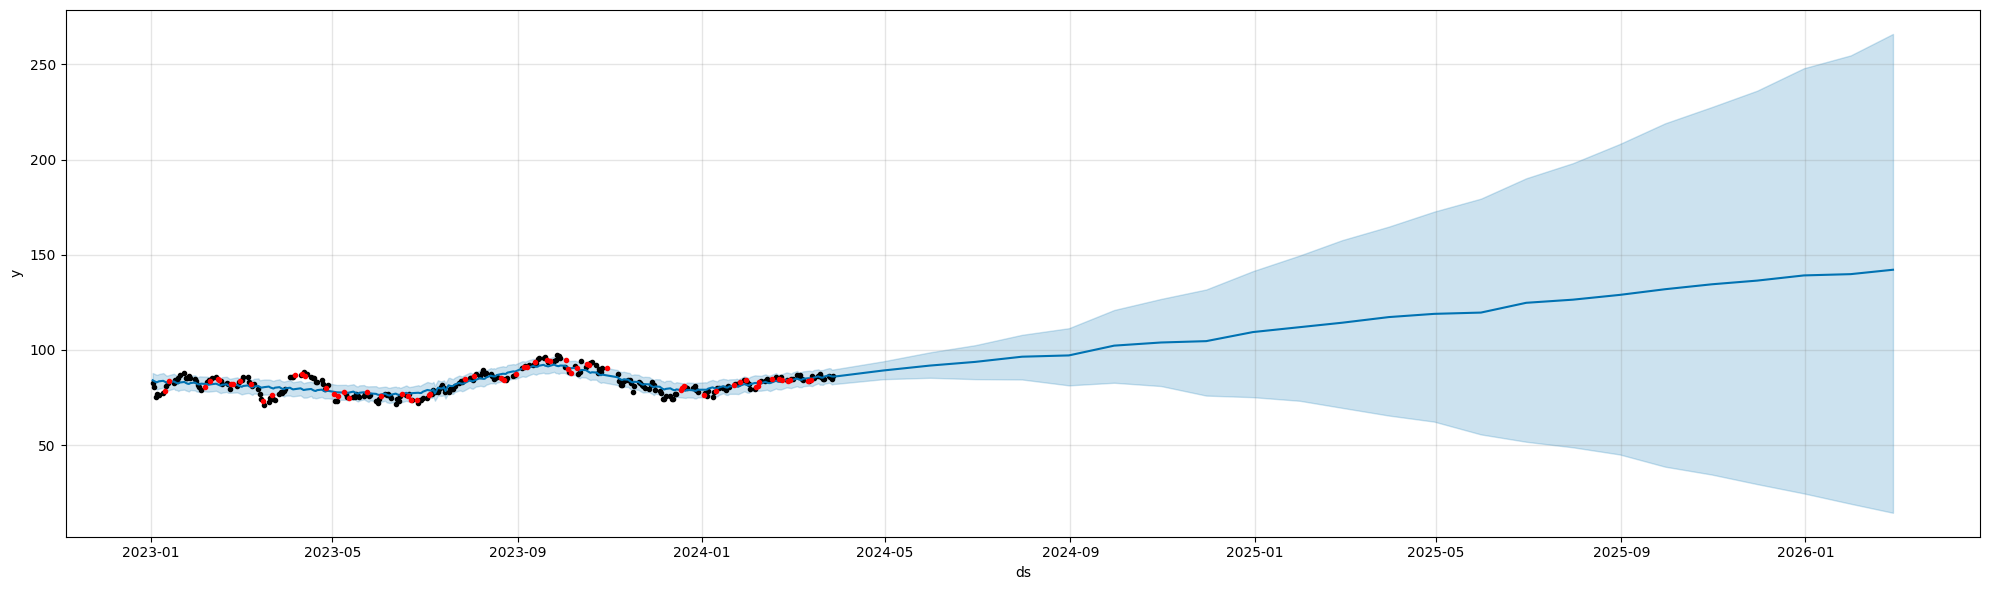

In [ ]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

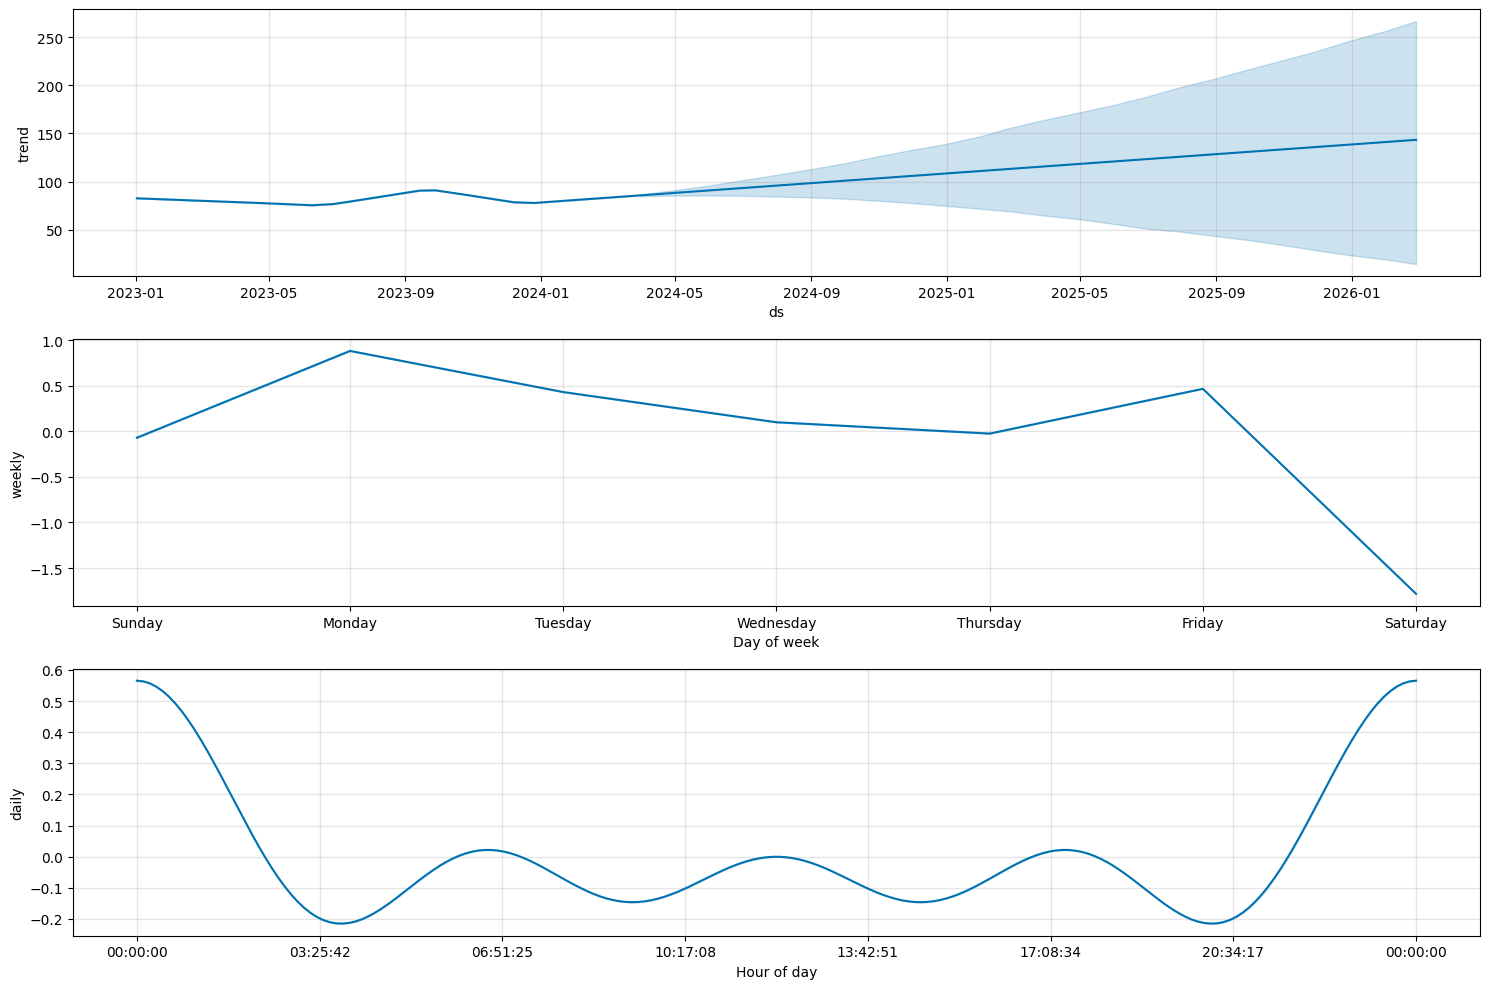

In [ ]:
modelo.plot_components(previsao, figsize=(15,10));

In [ ]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 2.92%


Portanto, um MAPE de 5.29% significa que, em média, as previsões do modelo têm um erro absoluto médio de 5.29% em relação aos valores reais.

##Cross Validation

In [ ]:
df_cv = cross_validation(modelo, initial='360 days', period='30 days', horizon = '30 days')

INFO:prophet:Making 3 forecasts with cutoffs between 2023-12-29 00:00:00 and 2024-02-27 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t28b1zp/fyf8tnb8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t28b1zp/u_ivpj_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11716', 'data', 'file=/tmp/tmp4t28b1zp/fyf8tnb8.json', 'init=/tmp/tmp4t28b1zp/u_ivpj_2.json', 'output', 'file=/tmp/tmp4t28b1zp/prophet_modelz9gkcqzu/prophet_model-20240406211212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:12:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:12:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t28b1zp/ge1_b8ao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4t28b1zp/99c1e11b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-01-03,74.154891,69.721786,77.958113,77.18,2023-12-29
1,2024-01-04,73.780644,69.683645,78.212252,75.79,2023-12-29
2,2024-01-05,74.374898,70.033895,78.702791,78.31,2023-12-29
3,2024-01-08,74.023449,69.952248,78.239927,75.47,2023-12-29
4,2024-01-09,73.341381,68.760792,77.305328,77.97,2023-12-29


In [ ]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,39.397531,6.276745,5.758833,0.068705,0.069085,0.071655,0.500000
1,4 days,37.397309,6.115334,5.633535,0.067714,0.067104,0.070562,0.500000
2,5 days,32.315787,5.684698,5.265976,0.064864,0.048539,0.067393,0.375000
3,6 days,13.177847,3.630130,3.479832,0.043259,0.044320,0.044288,0.500000
4,7 days,13.611056,3.689316,3.574782,0.043419,0.048457,0.044434,0.750000
5,8 days,19.620506,4.429504,4.402707,0.053323,0.052943,0.054796,0.750000
6,9 days,18.844019,4.340970,4.300709,0.051701,0.051553,0.053097,0.750000
7,10 days,11.110310,3.333213,3.084173,0.037225,0.035972,0.038042,0.875000
8,11 days,10.666212,3.265917,3.041089,0.037619,0.035972,0.038460,0.750000
9,12 days,30.059217,5.482629,4.520347,0.055482,0.044469,0.057811,0.500000


##Algoritimo LSTM (Long Short-Term Memory)

In [ ]:
df_1.tail()

,preco,MM30,MM180,DesvioPadrao,Banda Superior,Banda Inferior
data,,,,,,
2024-03-22,84.87,NaN,NaN,NaN,NaN,NaN
2024-03-25,86.18,NaN,NaN,NaN,NaN,NaN
2024-03-26,85.91,NaN,NaN,NaN,NaN,NaN
2024-03-27,84.94,NaN,NaN,NaN,NaN,NaN
2024-03-28,86.17,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_1.reset_index(inplace=True)
df_1.drop(columns=['MM30', 'MM180', 'DesvioPadrao', 'Banda Superior', 'Banda Inferior'], inplace=True)
df_1.rename(columns={'ds': 'data', 'y': 'preco'}, inplace=True)
df = df_1
df.tail()

,data,preco
309,2024-03-22,84.87
310,2024-03-25,86.18
311,2024-03-26,85.91
312,2024-03-27,84.94
313,2024-03-28,86.17


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    314 non-null    datetime64[ns]
 1   preco   314 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.0 KB


In [ ]:
close_data = df['preco'].values
close_data = close_data.reshape(-1,1) #transformar em array

##Normalizando os dados

In [ ]:
#df.reset_index(inplace=True)

In [ ]:
#df_1.reset_index(inplace=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [ ]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['data'][:split]
date_test = df['data'][split:]

print(len(close_train))
print(len(close_test))

251
63


In [ ]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [ ]:
from keras.losses import MeanSquaredError  # Importing MeanSquaredError class

np.random.seed(43)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)


Epoch 1/20
13/13 [==============================] - 2s 12ms/step - loss: 0.1504 - mean_squared_error: 0.1423
Epoch 2/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0268 - mean_squared_error: 0.0254
Epoch 3/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0172 - mean_squared_error: 0.0176
Epoch 4/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0178 - mean_squared_error: 0.0168
Epoch 5/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0166 - mean_squared_error: 0.0161
Epoch 6/20
13/13 [==============================] - 0s 13ms/step - loss: 0.0139 - mean_squared_error: 0.0134
Epoch 7/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0132 - mean_squared_error: 0.0128
Epoch 8/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0134 - mean_squared_error: 0.0127
Epoch 9/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0145 - mean_squared_error: 0.0148
Epoch 10/20
13/13 [===

In [ ]:
np.random.seed(43)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
13/13 [==============================] - 1s 7ms/step - loss: 0.1628 - mean_squared_error: 0.1551
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0685 - mean_squared_error: 0.0636
Epoch 3/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0223 - mean_squared_error: 0.0225
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0162 - mean_squared_error: 0.0163
Epoch 5/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0173 - mean_squared_error: 0.0164
Epoch 6/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0154 - mean_squared_error: 0.0152
Epoch 7/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0150 - mean_squared_error: 0.0143
Epoch 8/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0130 - mean_squared_error: 0.0129
Epoch 9/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0143 - mean_squared_error: 0.0137
Epoch 10/20
13/13 [=========

##MSE

In [ ]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

53/53 [==============================] - 0s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Erro Quadrático Médio 0.0031901721376925707


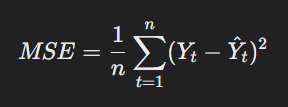

um MSE de 0.011025778017938137 significa que, em média, os quadrados dos erros das previsões do modelo são 0.011025778017938137. Em outras palavras, o MSE mede a média dos quadrados dos desvios das previsões em relação aos valores verdadeiros. Quanto menor o valor do MSE, melhor é a precisão do modelo em relação aos dados observados.

MAPE

In [ ]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

53/53 [==============================] - 0s 3ms/step
MAPE: 2.0464


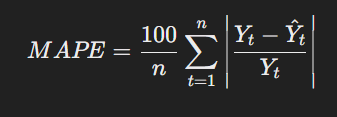

O MAPE de 4.3526% indica que, em média, as previsões do modelo têm um erro absoluto médio de 4.3526% em relação aos valores reais. Isso significa que, em média, as previsões do modelo estão incorretas em cerca de 4.3526% em relação aos valores reais.

##RMSE

In [ ]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error),
#que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.05648160884476088


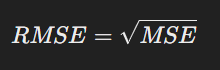

um RMSE de 0.10500370478196537 significa que, em média, o desvio padrão dos erros das previsões do modelo é de 0.10500370478196537. Em outras palavras, o RMSE fornece uma medida da dispersão dos erros das previsões em relação aos valores verdadeiros. Quanto menor o valor do RMSE, melhor é a precisão do modelo em relação aos dados observados.

#Predição

In [ ]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Preço"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

53/53 [==============================] - 0s 3ms/step


##Validando com suavização da série temporal

In [ ]:
df.tail()

,data,preco
309,2024-03-22,84.87
310,2024-03-25,86.18
311,2024-03-26,85.91
312,2024-03-27,84.94
313,2024-03-28,86.17


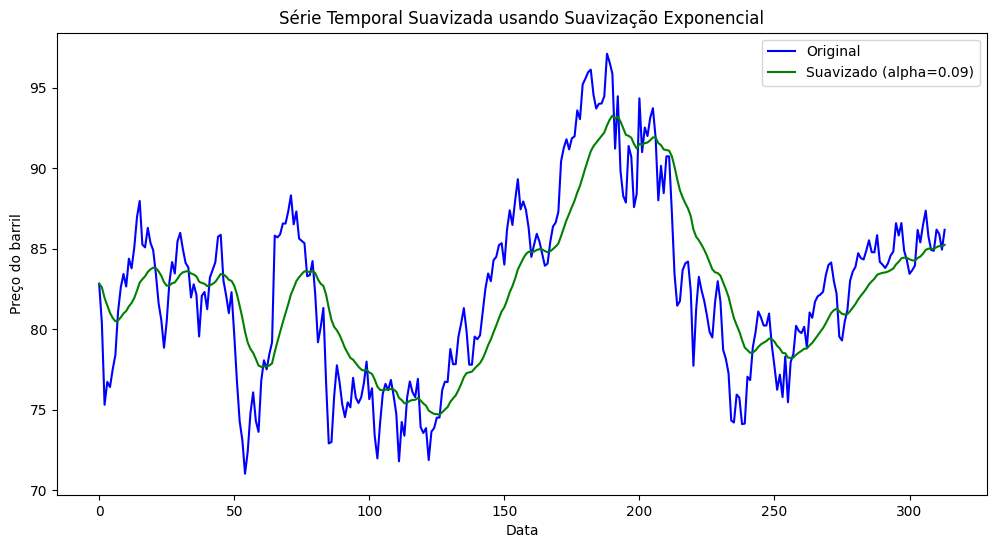

In [ ]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df['Smoothed_Close'] = df['preco'].ewm(alpha=alpha, adjust=False).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['preco'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='g')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço do barril')
plt.legend()
plt.show()

## Teste de estacionariedade (ADF Test)

In [ ]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.281483179391237
p-value: 0.17800957490486236
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.281483179391237
Valor-p: 0.17800957490486236
Valores Críticos:
   1%: -3.4514843502727306
   5%: -2.8708485956333556
   10%: -2.571729625657462


In [ ]:
df.drop(columns=['preco'], inplace=True)
df.head()

,data,Smoothed_Close
0,2023-01-02,82.820000
1,2023-01-03,82.598600
2,2023-01-04,81.942626
3,2023-01-05,81.473490
4,2023-01-06,81.017776


In [ ]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [ ]:
close_data

array([[4.37338062e-01],
       [4.25405417e-01],
       [3.90050830e-01],
       [3.64766107e-01],
       [3.40204795e-01],
       [3.23141230e-01],
       [3.11978988e-01],
       [3.14966660e-01],
       [3.24864433e-01],
       [3.37945967e-01],
       [3.46066642e-01],
       [3.61848114e-01],
       [3.73298851e-01],
       [3.90024892e-01],
       [4.14364847e-01],
       [4.41364875e-01],
       [4.52789588e-01],
       [4.62361462e-01],
       [4.76941178e-01],
       [4.85697597e-01],
       [4.91434630e-01],
       [4.89476340e-01],
       [4.78914586e-01],
       [4.64258694e-01],
       [4.42578681e-01],
       [4.30756460e-01],
       [4.31833871e-01],
       [4.38877651e-01],
       [4.41843516e-01],
       [4.54243792e-01],
       [4.68050390e-01],
       [4.75666712e-01],
       [4.78474497e-01],
       [4.79719900e-01],
       [4.71782466e-01],
       [4.68536950e-01],
       [4.62430595e-01],
       [4.44310579e-01],
       [4.40093558e-01],
       [4.37371722e-01],


In [ ]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['data'][:split]
date_test = df['data'][split:]

print(len(close_train))
print(len(close_test))

251
63


In [ ]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina
look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [ ]:
np.random.seed(43)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 6ms/step - loss: 0.1995 - mean_squared_error: 0.1916
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1079 - mean_squared_error: 0.1027
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0499 - mean_squared_error: 0.0472
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0138 - mean_squared_error: 0.0133
Epoch 5/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0099 - mean_squared_error: 0.0097
Epoch 6/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0066
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0039
Epoch 8/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0036
Epoch 9/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0030
Epoch 10/100
13/13 

In [ ]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")

58/58 [==============================] - 0s 2ms/step
MAPE: 0.60%


In [ ]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

58/58 [==============================] - 0s 2ms/step - loss: 1.5652e-04 - mean_squared_error: 1.5652e-04
Erro Quadrático Médio: 0.00015652368892915547


In [ ]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error),
#que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])
print("RMSE:", rmse_value)

RMSE: 0.012510942767399884


In [ ]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Preço"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

fig.update_layout(
    autosize=False,
    width=1200,  # Largura em pixels
    height=800,  # Altura em pixels
)

fig.show()

58/58 [==============================] - 0s 2ms/step


#forecasting

In [ ]:
close_data = close_data.reshape((-1))
# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas
def predict_dates(num_prediction):
    last_date = df['data'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 21ms/step


In [ ]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Preço"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

##Organizando os dados em um dataframe

In [ ]:
df = pd.DataFrame(df)
df_past = df[['data','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['data'] = pd.to_datetime(df_past['data'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

<ipython-input-511-814df7ec8430>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,data,Actual,Forecast
0,2023-01-02,82.820000,NaN
1,2023-01-03,82.598600,NaN
2,2023-01-04,81.942626,NaN


In [ ]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [ ]:
df_future = pd.DataFrame(columns=['data', 'Actual', 'Forecast'])
df_future['data'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,data,Actual,Forecast
0,2024-03-28,NaN,85.236750
1,2024-03-29,NaN,85.152122
2,2024-03-30,NaN,85.157308
3,2024-03-31,NaN,85.133464
4,2024-04-01,NaN,85.118273


In [ ]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('data')
results.head(5)

,Actual,Forecast
data,,
2023-01-02,82.820000,NaN
2023-01-03,82.598600,NaN
2023-01-04,81.942626,NaN
2023-01-05,81.473490,NaN
2023-01-06,81.017776,NaN


In [ ]:
results.tail(5)

,Actual,Forecast
data,,
2024-04-23,NaN,84.841623
2024-04-24,NaN,84.832363
2024-04-25,NaN,84.823252
2024-04-26,NaN,84.814319
2024-04-27,NaN,84.805553


In [ ]:
print(results)

               Actual   Forecast
data                            
2023-01-02  82.820000        NaN
2023-01-03  82.598600        NaN
2023-01-04  81.942626        NaN
2023-01-05  81.473490        NaN
2023-01-06  81.017776        NaN
...               ...        ...
2024-04-23        NaN  84.841623
2024-04-24        NaN  84.832363
2024-04-25        NaN  84.823252
2024-04-26        NaN  84.814319
2024-04-27        NaN  84.805553

[345 rows x 2 columns]


In [ ]:
results.tail(30)

,Actual,Forecast
data,,
2024-03-29,NaN,85.152122
2024-03-30,NaN,85.157308
2024-03-31,NaN,85.133464
2024-04-01,NaN,85.118273
2024-04-02,NaN,85.102299
2024-04-03,NaN,85.086090
2024-04-04,NaN,85.070883
2024-04-05,NaN,85.055728
2024-04-06,NaN,85.041075
